In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")

mpl.rcParams['figure.figsize'] = [8.0*2, 6.0*2]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 30
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'



# Introduction

On fait des plots sur les runs

In [3]:
from problem.workflow import pprint

# Data

In [4]:
from problem.higgs_geant import load_data

In [5]:
print('Loading data ...')
data, _ = load_data()
print('Done !')

Loading data ...
Done !


In [6]:
data.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,1.0
1,160.937,68.768,103.235,48.146,0.00,0.000,0.000,3.473,2.078,125.157,...,1,46.226,0.725,1.158,0.000,0.00,0.000,46.226,0.681042,0.0
2,0.000,162.172,125.953,35.635,0.00,0.000,0.000,3.148,9.336,197.814,...,1,44.251,2.053,-2.028,0.000,0.00,0.000,44.251,0.715742,0.0
3,143.905,81.417,80.943,0.414,0.00,0.000,0.000,3.310,0.414,75.968,...,0,0.000,0.000,0.000,0.000,0.00,0.000,-0.000,1.660654,0.0
4,175.864,16.915,134.805,16.405,0.00,0.000,0.000,3.891,16.405,57.983,...,0,0.000,0.000,0.000,0.000,0.00,0.000,0.000,1.904263,0.0


# Load models

In [7]:
from problem.higgs_geant import get_save_directory
from problem.higgs_geant import skew
from problem.higgs_geant import tangent
from problem.higgs_geant import get_cv_iter


In [8]:
def load_models(model_class, *args, **kwargs):
    models = []
    cv_iter = get_cv_iter(data, data['Label'])
    n_cv = len(cv_iter)
    pprint('Loading', n_cv, model_class.__name__)
    for i in range(n_cv):
        model = model_class(*args, **kwargs)
        save_directory = get_save_directory()
        model_name = '{}-{}'.format(model.get_name(), i)
        path = os.path.join(save_directory, model_name)
        model.load(path)
        models.append(model)
    return models

In [9]:
from models.higgsml import NeuralNetModel
from models.higgsml import AugmentedNeuralNetModel
from models.higgsml import TangentPropModel
from models.higgsml import AugmentedTangentPropModel
from models.higgsml import PivotModel


# Test submission

In [10]:
from problem.higgs_geant import test_submission


In [11]:
from experiment import basic_metrics_xp
from experiment import merge_decision_xp
from experiment import complete_metrics_xp
from experiment import systematic_xp
from experiment import reduce_mean_xp
from experiment import reduce_std_xp

def get_syst_xp(xp, training_TES=1.0, n_bin=5000):
    xp = basic_metrics_xp(xp, n_bin=n_bin)
    xp = merge_decision_xp(xp)
    xp = complete_metrics_xp(xp)
    syst_xp = systematic_xp(xp, training_TES)
    return syst_xp

def get_mean_std_xp(xp, training_TES=1.0, n_bin=5000):
    syst_xp = get_syst_xp(xp, training_TES, n_bin=n_bin)
    xp_mean = reduce_mean_xp(syst_xp)
    xp_std = reduce_std_xp(syst_xp)
    return xp_mean, xp_std

In [12]:
# z_list = list(range(-50, 51, 10)) + list(range(-5, 6, 1))
# z_list = sorted(z_list)
# z_list = np.linspace(-10, 10, num=20)
z_list = (0.97, 1.0, 1.03)

print( z_list )

(0.97, 1.0, 1.03)


In [13]:
NN_models = load_models(NeuralNetModel, n_steps=10000, batch_size=1024, cuda=True)
NN_xp = test_submission(data, NN_models, all_sysTES=z_list)
NN_mean, NN_std = get_mean_std_xp( NN_xp )


2018-02-20 15:57:22 Loading 12 NeuralNetModel
2018-02-20 15:57:29 testing model 1/12
2018-02-20 15:57:34 testing model 2/12
2018-02-20 15:57:38 testing model 3/12
2018-02-20 15:57:43 testing model 4/12
2018-02-20 15:57:47 testing model 5/12
2018-02-20 15:57:51 testing model 6/12
2018-02-20 15:57:56 testing model 7/12
2018-02-20 15:58:00 testing model 8/12
2018-02-20 15:58:05 testing model 9/12
2018-02-20 15:58:09 testing model 10/12
2018-02-20 15:58:13 testing model 11/12
2018-02-20 15:58:18 testing model 12/12
2018-02-20 15:58:20 Done.


In [14]:
PAN_0_models = load_models(PivotModel, skewing_function=skew, batch_size=1024, n_recovery_steps=5,
                         n_clf_pre_training_steps=3000, n_adv_pre_training_steps=3000, n_steps=10000,
                         width=0.03, trade_off=0.0, cuda=True)
PAN_0_xp = test_submission(data, PAN_0_models, all_sysTES=z_list)
PAN_0_mean, PAN_0_std = get_mean_std_xp( PAN_0_xp )


2018-02-20 15:58:24 Loading 12 PivotModel
2018-02-20 15:58:27 testing model 1/12
2018-02-20 15:58:32 testing model 2/12
2018-02-20 15:58:36 testing model 3/12
2018-02-20 15:58:40 testing model 4/12
2018-02-20 15:58:44 testing model 5/12
2018-02-20 15:58:48 testing model 6/12
2018-02-20 15:58:52 testing model 7/12
2018-02-20 15:58:56 testing model 8/12
2018-02-20 15:59:00 testing model 9/12
2018-02-20 15:59:04 testing model 10/12
2018-02-20 15:59:08 testing model 11/12
2018-02-20 15:59:12 testing model 12/12
2018-02-20 15:59:14 Done.


In [15]:
PAN_001_models = load_models(PivotModel, skewing_function=skew, batch_size=1024, n_recovery_steps=5,
                         n_clf_pre_training_steps=3000, n_adv_pre_training_steps=3000, n_steps=10000,
                         width=0.03, trade_off=0.01, cuda=True)
PAN_001_xp = test_submission(data, PAN_001_models, all_sysTES=z_list)
PAN_001_mean, PAN_001_std = get_mean_std_xp( PAN_001_xp )


2018-02-20 15:59:18 Loading 12 PivotModel
2018-02-20 15:59:21 testing model 1/12
2018-02-20 15:59:25 testing model 2/12
2018-02-20 15:59:29 testing model 3/12
2018-02-20 15:59:33 testing model 4/12
2018-02-20 15:59:37 testing model 5/12
2018-02-20 15:59:41 testing model 6/12
2018-02-20 15:59:45 testing model 7/12
2018-02-20 15:59:49 testing model 8/12
2018-02-20 15:59:53 testing model 9/12
2018-02-20 15:59:56 testing model 10/12
2018-02-20 16:00:00 testing model 11/12
2018-02-20 16:00:04 testing model 12/12
2018-02-20 16:00:06 Done.


In [16]:
PAN_01_models = load_models(PivotModel, skewing_function=skew, batch_size=1024, n_recovery_steps=5,
                         n_clf_pre_training_steps=3000, n_adv_pre_training_steps=3000, n_steps=10000,
                         width=0.03, trade_off=0.1, cuda=True)
PAN_01_xp = test_submission(data, PAN_01_models, all_sysTES=z_list)
PAN_01_mean, PAN_01_std = get_mean_std_xp( PAN_01_xp )


2018-02-20 16:00:10 Loading 12 PivotModel
2018-02-20 16:00:13 testing model 1/12
2018-02-20 16:00:17 testing model 2/12
2018-02-20 16:00:21 testing model 3/12
2018-02-20 16:00:25 testing model 4/12
2018-02-20 16:00:29 testing model 5/12
2018-02-20 16:00:33 testing model 6/12
2018-02-20 16:00:37 testing model 7/12
2018-02-20 16:00:41 testing model 8/12
2018-02-20 16:00:45 testing model 9/12
2018-02-20 16:00:49 testing model 10/12
2018-02-20 16:00:53 testing model 11/12
2018-02-20 16:00:57 testing model 12/12
2018-02-20 16:00:59 Done.


In [17]:
PAN_1_models = load_models(PivotModel, skewing_function=skew, batch_size=1024, n_recovery_steps=5,
                         n_clf_pre_training_steps=3000, n_adv_pre_training_steps=3000, n_steps=10000,
                         width=0.03, trade_off=1.0, cuda=True)
PAN_1_xp = test_submission(data, PAN_1_models, all_sysTES=z_list)
PAN_1_mean, PAN_1_std = get_mean_std_xp( PAN_1_xp )


2018-02-20 16:01:04 Loading 12 PivotModel
2018-02-20 16:01:07 testing model 1/12
2018-02-20 16:01:11 testing model 2/12
2018-02-20 16:01:15 testing model 3/12
2018-02-20 16:01:19 testing model 4/12
2018-02-20 16:01:23 testing model 5/12
2018-02-20 16:01:27 testing model 6/12
2018-02-20 16:01:31 testing model 7/12
2018-02-20 16:01:35 testing model 8/12
2018-02-20 16:01:39 testing model 9/12
2018-02-20 16:01:43 testing model 10/12
2018-02-20 16:01:47 testing model 11/12
2018-02-20 16:01:51 testing model 12/12
2018-02-20 16:01:53 Done.


In [18]:
PAN_10_models = load_models(PivotModel, skewing_function=skew, batch_size=1024, n_recovery_steps=5,
                         n_clf_pre_training_steps=3000, n_adv_pre_training_steps=3000, n_steps=10000,
                         width=0.03, trade_off=10.0, cuda=True)
PAN_10_xp = test_submission(data, PAN_10_models, all_sysTES=z_list)
PAN_10_mean, PAN_10_std = get_mean_std_xp( PAN_10_xp )


2018-02-20 16:01:57 Loading 12 PivotModel
2018-02-20 16:02:00 testing model 1/12
2018-02-20 16:02:04 testing model 2/12
2018-02-20 16:02:08 testing model 3/12
2018-02-20 16:02:12 testing model 4/12
2018-02-20 16:02:16 testing model 5/12
2018-02-20 16:02:20 testing model 6/12
2018-02-20 16:02:24 testing model 7/12
2018-02-20 16:02:28 testing model 8/12
2018-02-20 16:02:32 testing model 9/12
2018-02-20 16:02:36 testing model 10/12
2018-02-20 16:02:40 testing model 11/12
2018-02-20 16:02:44 testing model 12/12
2018-02-20 16:02:46 Done.


In [19]:
PAN_100_models = load_models(PivotModel, skewing_function=skew, batch_size=1024, n_recovery_steps=5,
                         n_clf_pre_training_steps=3000, n_adv_pre_training_steps=3000, n_steps=10000,
                         width=0.03, trade_off=100.0, cuda=True)
PAN_100_xp = test_submission(data, PAN_100_models, all_sysTES=z_list)
PAN_100_mean, PAN_100_std = get_mean_std_xp( PAN_100_xp )


2018-02-20 16:02:50 Loading 12 PivotModel
2018-02-20 16:02:53 testing model 1/12
2018-02-20 16:02:57 testing model 2/12
2018-02-20 16:03:02 testing model 3/12
2018-02-20 16:03:05 testing model 4/12
2018-02-20 16:03:09 testing model 5/12
2018-02-20 16:03:13 testing model 6/12
2018-02-20 16:03:17 testing model 7/12
2018-02-20 16:03:21 testing model 8/12
2018-02-20 16:03:25 testing model 9/12
2018-02-20 16:03:29 testing model 10/12
2018-02-20 16:03:33 testing model 11/12
2018-02-20 16:03:37 testing model 12/12
2018-02-20 16:03:39 Done.


# Plot


- What about confusion matrices ???


## Utils

In [20]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [21]:
def tes_to_str(TES):
    return '{:+d}%'.format( int(np.round((TES-1)*100)) )

## Graphics


In [22]:
CHOSEN_TES = 1.03

In [23]:
means = [NN_mean, PAN_0_mean, PAN_01_mean, PAN_1_mean, PAN_10_mean, PAN_100_mean, ]
stds = [NN_std, PAN_0_std, PAN_01_std, PAN_1_std, PAN_10_std, PAN_100_std, ]
names = ['NN', '0', '0.1', '1', '10', '100', ]

# means = [PAN_01_mean, PAN_1_mean, PAN_10_mean, PAN_100_mean, ]
# stds = [PAN_01_std, PAN_1_std, PAN_10_std, PAN_100_std, ]
# names = ['0.1', '1', '10', '100', ]

# means = [PAN_01_mean_acc, PAN_1_mean_acc, PAN_10_mean_acc, PAN_100_mean_acc, ]
# stds = [PAN_01_std_acc, PAN_1_std_acc, PAN_10_std_acc, PAN_100_std_acc, ]
# names = ['0.1', '1', '10', '100', ]


## Sigma mu

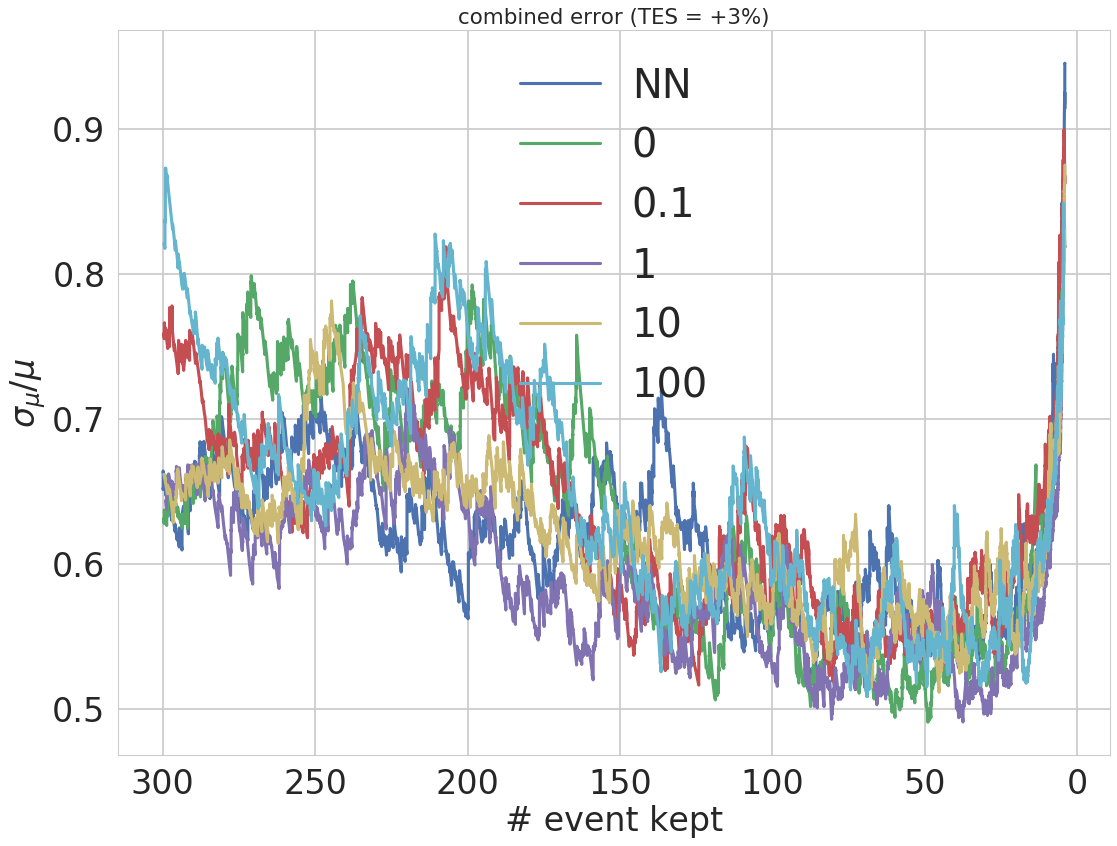

In [24]:
START = 300
STOP = 4

for xp_mean, xp_std, name in zip(means, stds, names):
    

    xx = xp_mean[CHOSEN_TES]['TP'] + xp_mean[CHOSEN_TES]['FP']
    index = xx.loc[ (xx < START) & (xx > STOP)].index
    #xx = (1 - xx / xx[0]) * 100  # Percentage
    xx = xx[index]

    mean = xp_mean[CHOSEN_TES]['sigma_mu'][index]
    std = xp_std[CHOSEN_TES]['sigma_mu'][index]
    
    # Smoothing
#     mean = savitzky_golay(mean.values, 1001, 3)
#     std = savitzky_golay(std.values, 1001, 3)
    
    plt.plot(xx, mean, label=name)
#     plt.fill_between(xx, mean+std, mean-std, alpha=0.5)
    plt.title('combined error (TES = {})'.format(tes_to_str(CHOSEN_TES)))
    
# plt.ylim(0, 10)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('# event kept')
plt.ylabel('$\sigma_\mu/\mu$')
plt.show()

## Syst Error

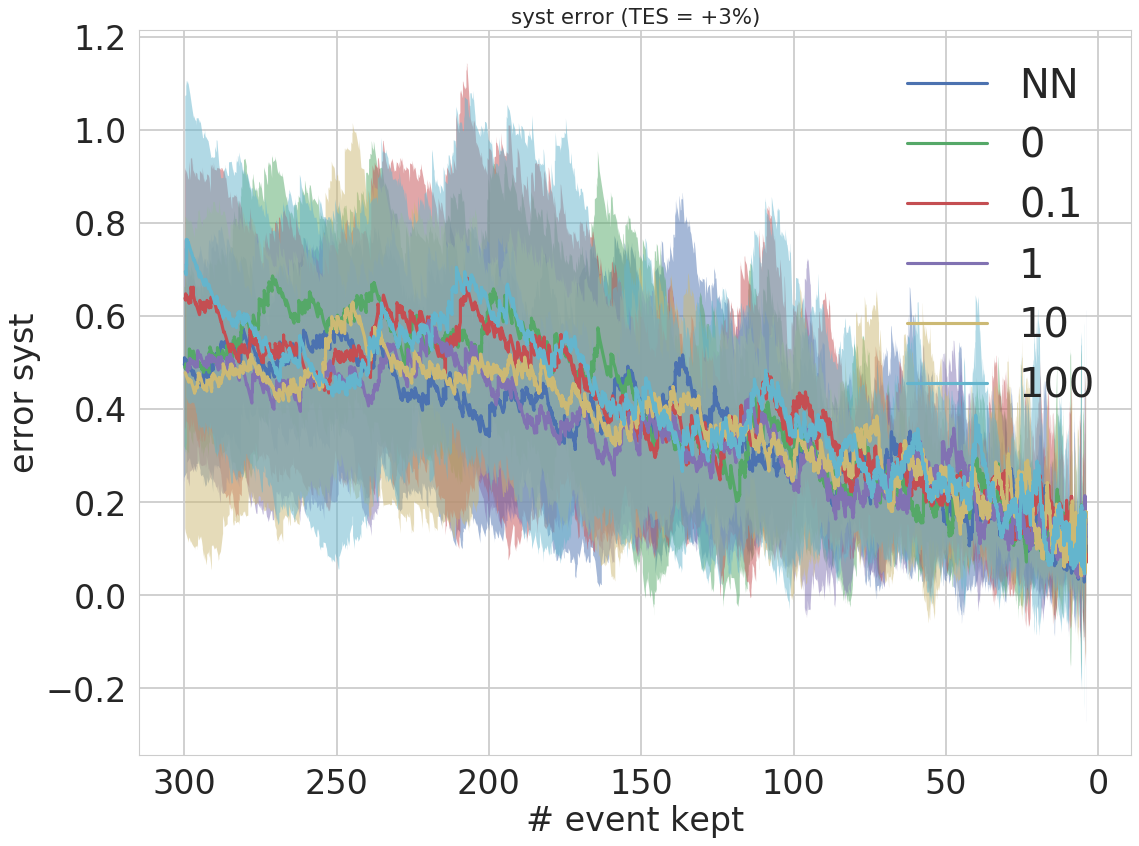

In [25]:
START = 300
STOP = 4

for xp_mean, xp_std, name in zip(means, stds, names):

    xx = xp_mean[CHOSEN_TES]['TP'] + xp_mean[CHOSEN_TES]['FP']
    index = xx.loc[ (xx < START) & (xx > STOP)].index
    #xx = (1 - xx / xx[0]) * 100  # Percentage
    xx = xx[index]

    mean = xp_mean[CHOSEN_TES]['error_syst'][index]
    std = xp_std[CHOSEN_TES]['error_syst'][index]
    
    # Smoothing
#     mean = savitzky_golay(mean.values, 1001, 3)
#     std = savitzky_golay(std.values, 1001, 3)
    
    plt.plot(xx, mean, label=name)
    plt.fill_between(xx, mean+std, mean-std, alpha=0.5)
    plt.title('syst error (TES = {})'.format(tes_to_str(CHOSEN_TES)))
    
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('# event kept')
plt.ylabel('error syst')
plt.show()

## Stat error

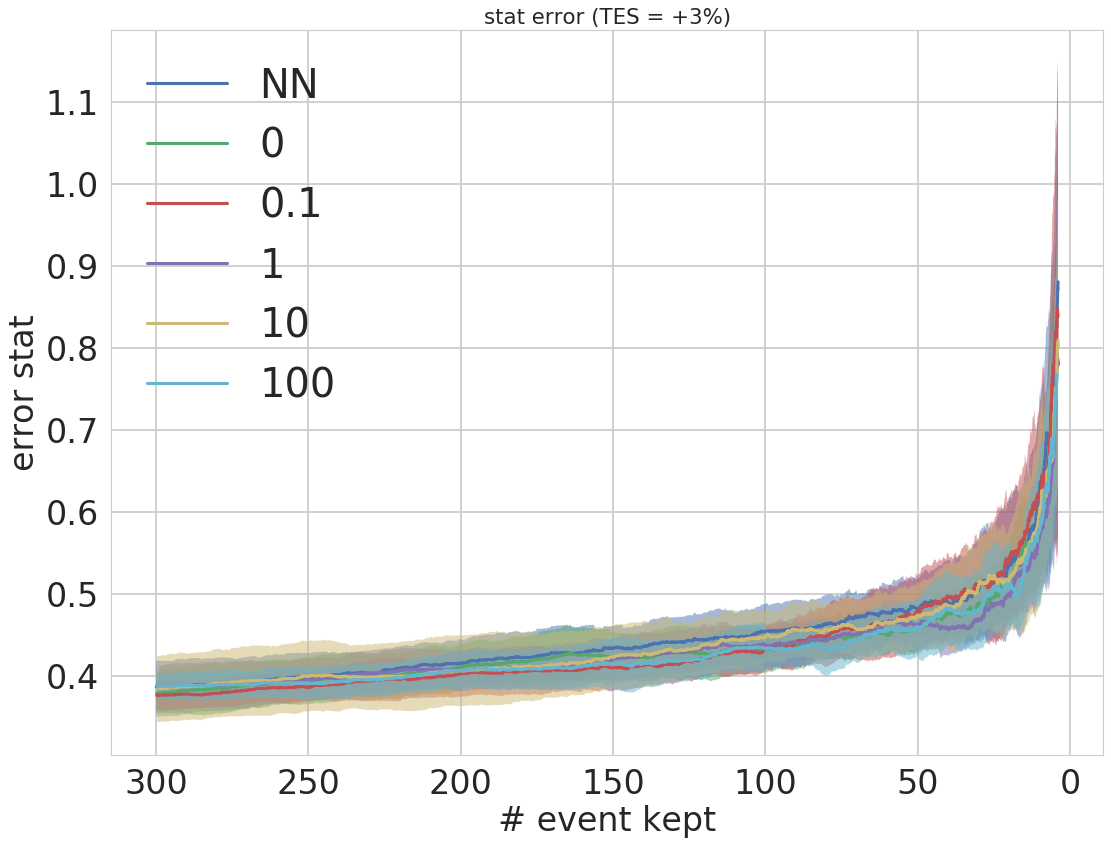

In [26]:
START = 300
STOP = 4

for xp_mean, xp_std, name in zip(means, stds, names):

    xx = xp_mean[CHOSEN_TES]['TP'] + xp_mean[CHOSEN_TES]['FP']
    index = xx.loc[ (xx < START) & (xx > STOP)].index
    #xx = (1 - xx / xx[0]) * 100  # Percentage
    xx = xx[index]

    mean = xp_mean[CHOSEN_TES]['error_stat'][index]
    std = xp_std[CHOSEN_TES]['error_stat'][index]
    
    # Smoothing
#     mean = savitzky_golay(mean.values, 1001, 3)
#     std = savitzky_golay(std.values, 1001, 3)
    
    plt.plot(xx, mean, label=name)
    plt.fill_between(xx, mean+std, mean-std, alpha=0.5)
    plt.title('stat error (TES = {})'.format(tes_to_str(CHOSEN_TES)))
    
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('# event kept')
plt.ylabel('error stat')
plt.show()

## Losses

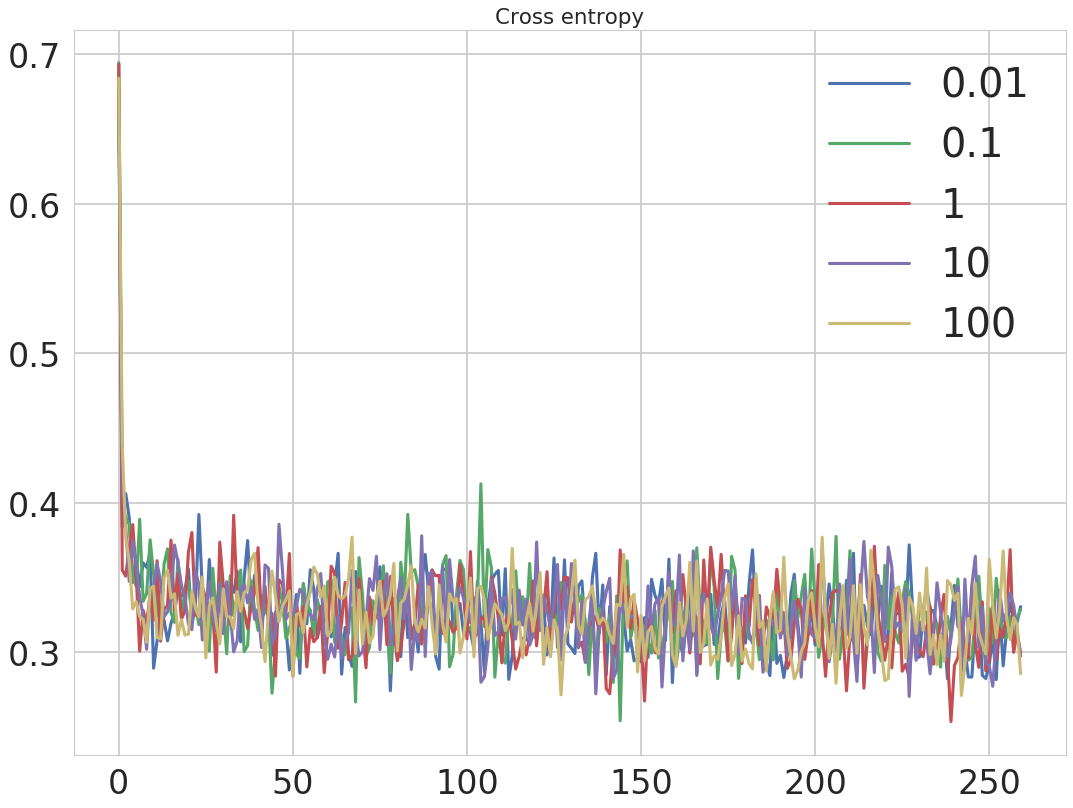

In [27]:
i = 0

plt.plot(PAN_001_models[i].dloss_hook.losses[::50], label='0.01')
plt.plot(PAN_01_models[i].dloss_hook.losses[::50], label='0.1')
plt.plot(PAN_1_models[i].dloss_hook.losses[::50], label='1')
plt.plot(PAN_10_models[i].dloss_hook.losses[::50], label='10')
plt.plot(PAN_100_models[i].dloss_hook.losses[::50], label='100')

plt.title('Cross entropy')
plt.legend()
plt.show()

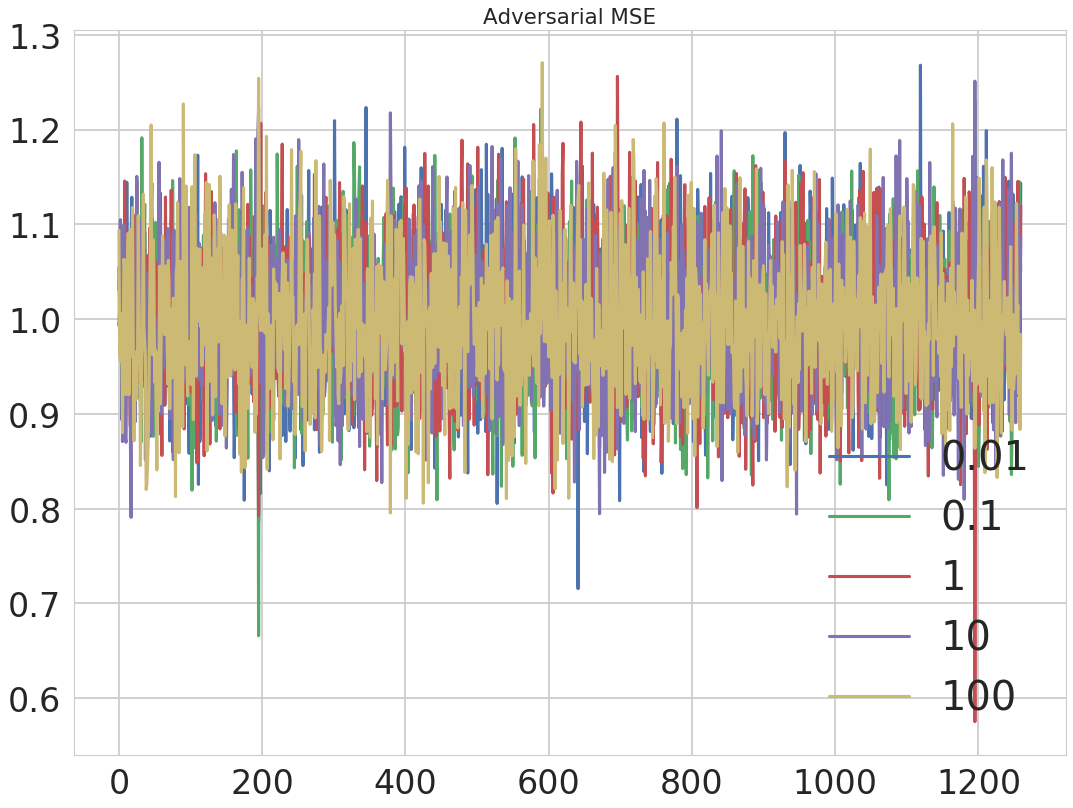

In [29]:
i = 0

plt.plot(PAN_001_models[i].rloss_hook.losses[::50], label='0.01')
plt.plot(PAN_01_models[i].rloss_hook.losses[::50], label='0.1')
plt.plot(PAN_1_models[i].rloss_hook.losses[::50], label='1')
plt.plot(PAN_10_models[i].rloss_hook.losses[::50], label='10')
plt.plot(PAN_100_models[i].rloss_hook.losses[::50], label='100')

#plt.ylim((0, 0.005))
plt.title('Adversarial MSE')
plt.legend()
plt.show()

# Playground